# |In this notebook we fit an ensemble SEIR model with hidden states to the Russia Covid-19 data

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm
from copy import deepcopy
from scipy.special import softmax
from sklearn.metrics import mean_absolute_error
from scipy.stats import iqr
import joblib

In [44]:
sns.set()
%matplotlib inline

In [45]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%autoreload 2

In [47]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.ensemble import EnsembleModel
from sir_models.utils import stepwise, eval_k_days_ahead, smape

# Load data

In [6]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)

In [7]:

useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df['total_deaths'] = df.total_deaths.fillna(0)
df['new_deaths'] = df.new_deaths.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2,2,2,2,2
new_cases,2,0,0,0,0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,0,0,0,0,0
new_deaths,0,0,0,0,0
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df.fillna(0)

# Define model and fitter

In [9]:
class SEIRHidden_OWID(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['base_population'].value = df.iloc[0].population
        return params


# Model

In [10]:
train_subset = df[
                #(df.date >= '2020-03-25') & 
                  (df.date <= '2020-11-30')]
train_subset.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52406,Russia,2020-01-31,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52407,Russia,2020-02-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52408,Russia,2020-02-02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52409,Russia,2020-02-03,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52410,Russia,2020-02-04,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0


In [11]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

52711   2020-12-01
52712   2020-12-02
52713   2020-12-03
Name: date, dtype: datetime64[ns]

In [48]:
stepwize_size = 60
model = SEIRHidden_OWID(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='new_deaths_smoothed',
     new_cases_col='new_cases_smoothed',
     save_params_every=10
)

ensemble = EnsembleModel.train(model, fitter, train_subset)

In [49]:
joblib.dump(ensemble, 'ensemble_russia.pkl')

['ensemble_russia.pkl']

In [50]:
result = ensemble.fitter.result
result

In [51]:
aggregate_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(train_subset)

In [52]:
(S, E, I, Iv, R, Rv, D, Dv) = aggregate_states
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = aggregate_daily 

In [53]:
train_t = np.arange(len(train_subset))

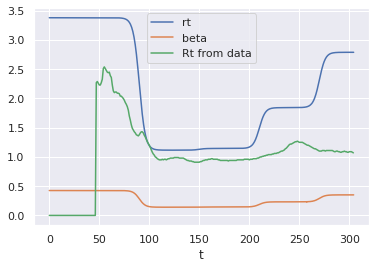

In [54]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(np.arange(len(train_subset.reproduction_rate)), train_subset.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

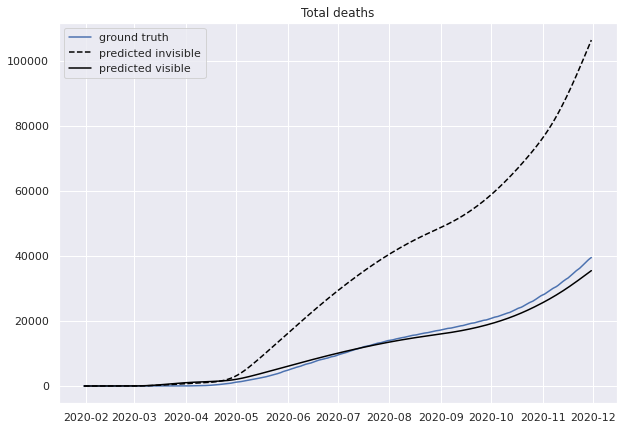

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

In [56]:
print("Coefficient of death underreporting:", (D/Dv).mean().round(3))

Coefficient of death underreporting: 2.294


In [57]:
mean_states = np.mean(model_states, axis=0)
iqr_states = iqr(model_states, axis=0)

mean_D = mean_states[-2]
mean_Dv = mean_states[-1]

iqr_D = iqr_states[-2]
iqr_Dv = iqr_states[-1]

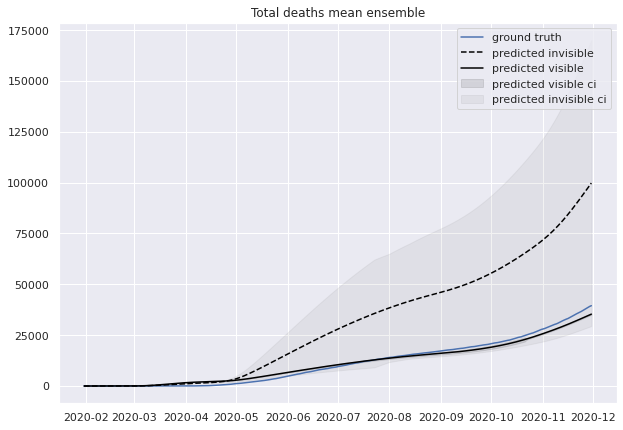

In [58]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, mean_D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, mean_Dv, label='predicted visible', color='black')

plt.fill_between(train_subset.date, (mean_Dv-iqr_Dv/2), (mean_Dv+iqr_Dv/2), color='black', label='predicted visible ci', alpha=.1)
plt.fill_between(train_subset.date, (mean_D-iqr_D/2), (mean_D+iqr_D/2), color='grey', label='predicted invisible ci', alpha=.1)

plt.legend()
plt.title('Total deaths mean ensemble')
plt.show()

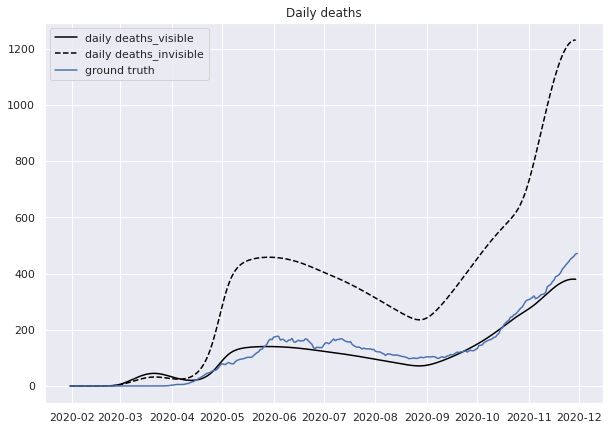

In [59]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

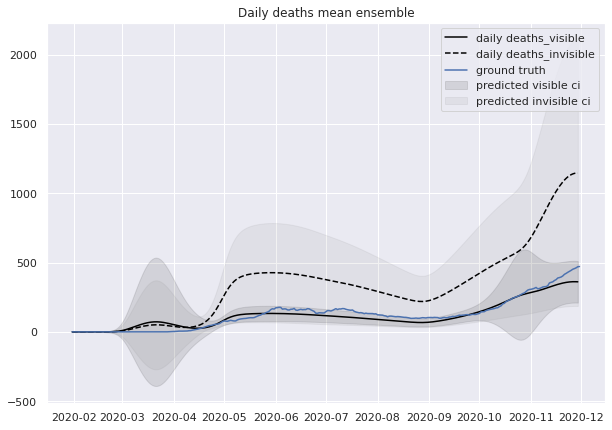

In [60]:
mean_daily_vals = np.mean(model_daily_vals, axis=0)
std_daily_vals = np.std(model_daily_vals, axis=0)

mean_daily_dead_visible = mean_daily_vals[-1]
mean_daily_dead_invisible = mean_daily_vals[-2]

std_daily_dead_visible = std_daily_vals[-1]
std_daily_dead_invisible = std_daily_vals[-2]

plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], mean_daily_dead_visible, label='daily deaths_visible', color='black')
plt.plot(train_subset.date[:-1], mean_daily_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')

plt.fill_between(train_subset.date[:-1], (mean_daily_dead_visible-std_daily_dead_visible), (mean_daily_dead_visible+std_daily_dead_visible), color='black', label='predicted visible ci', alpha=.1)
plt.fill_between(train_subset.date[:-1], (mean_daily_dead_invisible-std_daily_dead_invisible), (mean_daily_dead_invisible+std_daily_dead_invisible), color='grey', label='predicted invisible ci', alpha=.1)

plt.legend()
plt.title('Daily deaths mean ensemble')
plt.show()


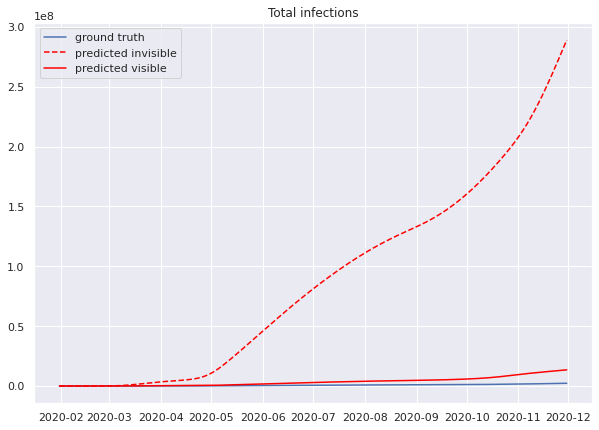

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted invisible', color='red', linestyle='dashed' )
plt.plot(train_subset.date, Iv.cumsum(), label='predicted visible', color='red')
plt.legend()
plt.title('Total infections')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Obtain forecast

In [30]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [31]:
train_t[-5:], test_t[:5]

(array([300, 301, 302, 303, 304]), array([305, 306, 307, 308, 309]))

In [32]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [33]:
test_aggregate_states, test_aggregate_daily, test_model_states, test_model_daily_vals, test_history = ensemble.predict(t=test_t, 
                                                                                                initial_conditions=test_initial_conds)

(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv) = test_aggregate_states

(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = test_aggregate_daily

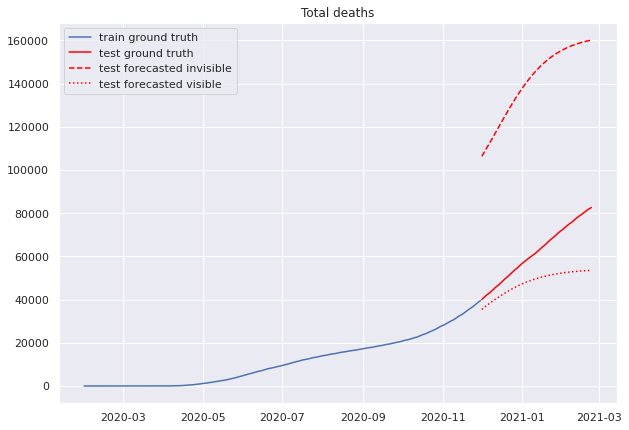

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_deaths'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

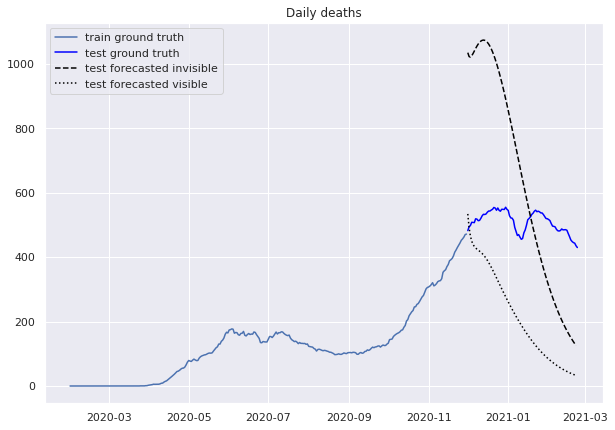

In [35]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_deaths_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

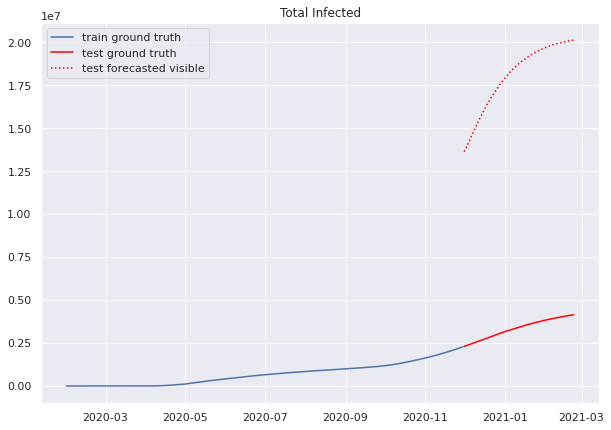

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='train ground truth')
# plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_cases'], label='test ground truth', color='red')
# plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, Iv.sum()+test_Iv.cumsum(), label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total Infected')
plt.show()

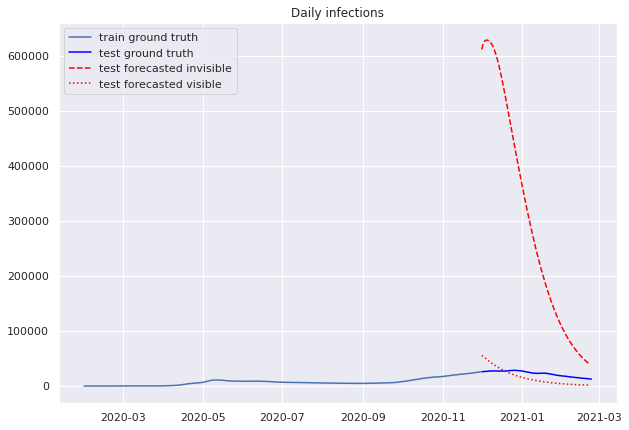

In [37]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_cases_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# 7-day ahead evaluate

In [38]:
def eval_k_days_ahead_ensemble(df, model_cls, fitter_cls, eval_period_start, n_eval_points=100, total_dead_col='total_deaths',
                       model_kwargs=None, fitter_kwargs=None, deaths_index_in_compartments=4, k=7):
    model_kwargs = model_kwargs or {}
    fitter_kwargs = fitter_kwargs or {'verbose': False}

    eval_points = np.arange(eval_period_start, (len(df)-k), (len(df)-k) // n_eval_points)
    pred_dates = []
    true_D = []
    baseline_pred_D = []
    model_pred_D = []
    fitters = []

    progress_bar = tqdm(eval_points, total=len(eval_points))
    for t in progress_bar:
        train_df = df.iloc[:t]

        model = model_cls(**model_kwargs)
        fitter = fitter_cls(**fitter_kwargs)
        ensemble = EnsembleModel.train(model, fitter, train_df)
        fitters.append(fitter)
        
        train_t = np.arange(len(train_df))
        aggregate_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(train_df)
        
        test_initial_conds = [compartment[-1] for compartment in aggregate_states]
        eval_t = np.arange(train_t[-1]+1, t+k, 1)

        test_aggregate_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(t=eval_t, 
                                                                                                            initial_conditions=test_initial_conds)

        D = test_aggregate_states[deaths_index_in_compartments]

        pred_dates.append(df.date.iloc[t:t+k].values)
        model_pred_D.append(D)
        baseline_pred_D.append([train_df.iloc[-1][total_dead_col]] * k)
        true_D.append(df[total_dead_col].iloc[eval_t].values)

    return pred_dates, baseline_pred_D, model_pred_D, true_D, fitters

In [39]:
eval_period_start_t = len(df[df.date < '2020-05-01'])

In [ ]:
pred_dates, baseline_pred_D, model_pred_D, true_D, fitters = eval_k_days_ahead_ensemble(df, 
                  SEIRHidden_OWID, 
                  HiddenCurveFitter, 
                  eval_period_start=eval_period_start_t, 
                  n_eval_points=10, 
                  total_dead_col='total_deaths', 
                  fitter_kwargs=dict(verbose=True,
                                     total_deaths_col='total_deaths',
                                     new_deaths_col='new_deaths_smoothed',
                                     total_cases_col='total_cases',
                                     new_cases_col='new_cases_smoothed'),
                  deaths_index_in_compartments=7,
                  k=30)

In [50]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [51]:
print('Mean overall error baseline', np.mean(overall_errors_baseline))
print('Mean overall error model', np.mean(overall_errors_model))

print('Mean point 30 days ahead error baseline', np.mean(point_errors_baseline))
print('Mean point 30 days ahead error model', np.mean(point_errors_model))

Mean overall error baseline 3943.416666666667
Mean overall error model 10712.501560444982
Mean point 30 days ahead error baseline 7894.625
Mean point 30 days ahead error model 13234.187050569137


In [52]:
train_errors = [np.abs([f.result.residual]).mean() for f in fitters]
test_errors = [np.abs(fitters[0].resid_transform(true, pred)).mean() for true, pred in zip(true_D, model_pred_D)]

In [53]:
x_dates = [d[-1] for d in pred_dates]

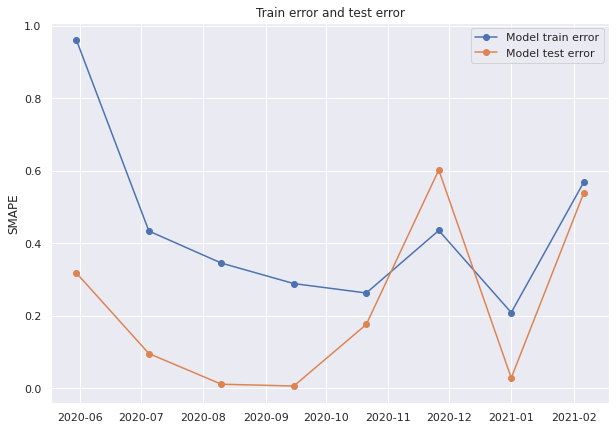

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, train_errors, label='Model train error', marker='o')
plt.plot(x_dates, test_errors, label='Model test error', marker='o')
plt.ylabel("SMAPE")
plt.legend()
plt.title('Train error and test error')
plt.show()

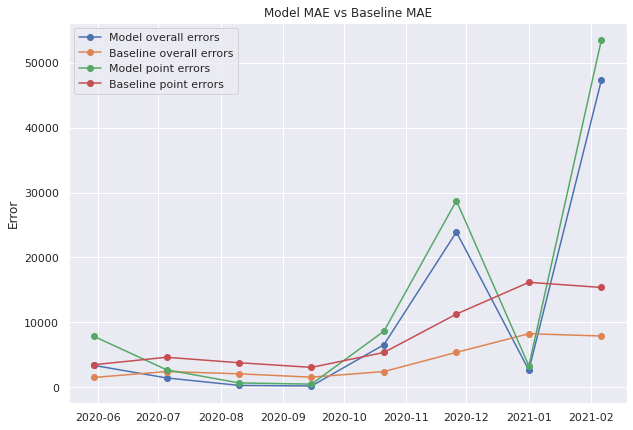

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors', marker='o')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors', marker='o')

plt.plot(x_dates, point_errors_model, label='Model point errors', marker='o')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors', marker='o')

plt.ylabel('Error')
plt.legend()
plt.title('Model MAE vs Baseline MAE')
plt.show()

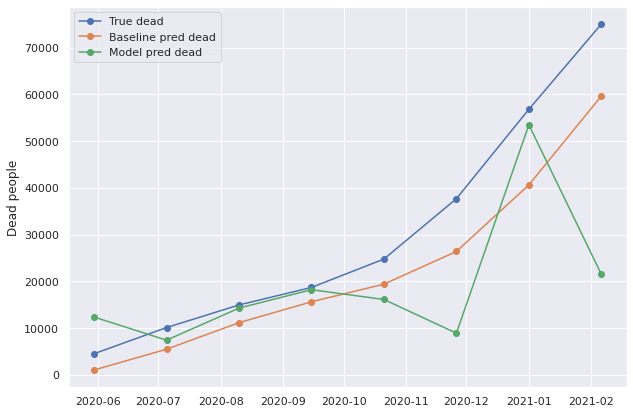

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, [v[-1] for v in true_D], label='True dead', marker='o')
plt.plot(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead', marker='o')
plt.plot(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead', marker='o')

plt.ylabel('Dead people')
plt.legend()
plt.show()